In [1]:
import numpy as np
import pandas as pd
import pickle
import re
from collections import Counter, defaultdict
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt

**Simple RNN Cell**

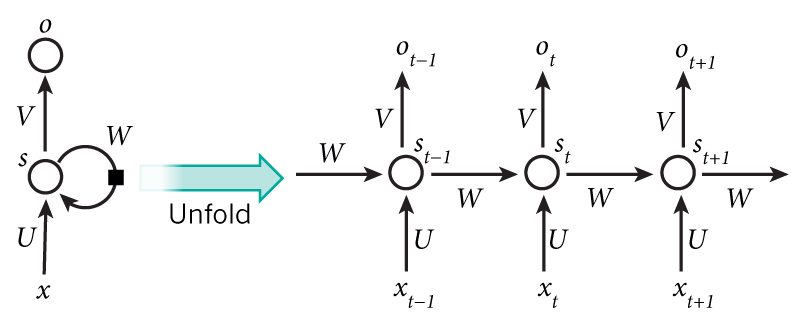

In [2]:
class SimpleRNN:
  def __init__(self, input_size, hidden_size):
    #input size : How many features each word has (embedding dimension)
    #hidden size: how much memory RNN has

    self.input_size = input_size
    self.hidden_size = hidden_size

    #weight matrix for input --> hidden(Wxh)

    self.Wxh = np.random.randn(input_size, hidden_size) * 0.1

    #weight matrix for hidden-->hidden (Whh)
    self.Whh = np.random.randn(hidden_size, hidden_size) * 0.1

    #Bias term
    self.bh = np.zeros((1, hidden_size))

  #Forward

  def forward(self, x, h_prev):

    #x is current word embedding ---> (1, input_size)
    #h_prev is hidden state from previous step ----> (1, hidden_size)

    #Process the current input
    input_contributed = np.dot(x, self.Wxh) #(1, input_size) X (input_size, hidden_Size) = (1, hidden_size)

    memory_contribution = np.dot(h_prev, self.Whh)

    combined = input_contributed + memory_contribution + self.bh

    h_next = np.tanh(combined)  #New hidden State

    return h_next



**Word Embedding**

In [7]:
class Word2Vec:
  def __init__(self):
    self.model = None
    self.vocab = {}
    self.embeddings = None

  def create_vocab(self, sentences):

    self.vocab = {"<PAD>" : 0, "<UNK>" : 1}  #Dictionary mapping word --> index

    #sentences: list of strings (e.g., ["My name is Dhamu", "You know me"])

    #Adding all unique words
    for sentence in sentences:
      words = sentence.lower().split()
      for word in words:
        if word not in self.vocab:
          self.vocab[word] = len(self.vocab)

    print(f"Vocab size : {len(self.vocab)}")

    return self.vocab

  def train_word2vec(self, sentences, embedding_dim = 50):
    print("Training Word2Vec ....")

    #Preparing sentences for word2vec

    word_lists = []
    for sentence in sentences:
      words = sentence.lower().split()
      word_lists.append(words)

    #Train word2vec
    self.model = Word2Vec(sentences = word_lists, vector_size = embedding_dim,
                          window = 3, min_count = 1, workers = 1)

    print("Word2Vec trained with {embedding_dim} dimensions")

    return self.model

  def create_embedding_matrix(self, vocab, embedding_dim):

    print("Creating embedding matrix ....")

    vocab_size = len(vocab)

    #Each word in vocab, if it's in word2vec vocabulary, Its vector is added to the matrix
    embeddings = np.random.randn(vocab_size, embedding_dim) * 0.1

    found = 0

    for word, index in vocab.items():
      if word in self.model.wv:
        embeddings[index] = self.model.wv[word]
        found += 1

    print(f"{found} words found in embedding")

    self.embeddings = embeddings

    return embeddings

**Translation**

In [11]:
class Translator:

  def __init__(self, embedding_dim = 50, hidden_size = 32):
    self.embedding_dim = embedding_dim  # No. of dimensions in each word vector
    self.hidden_size = hidden_size      # No. of units in hidden state of the RNN

    self.english_vocab = None
    self.telugu_vocab = None
    self.english_embeddings = None
    self.telugu_embeddings = None

    #RNN Cells
    self.encoder_rnn = None    # Encoder to process english input sentence
    self.decoder_rnn = None    # Decoder to generate telugu output sentence

    #Output layer weights
    self.output_weights = None
    self.output_bias = None

  # Preparing everything needed for translation -- Vocab embeddings, RNNs, Output Layer
  def prepare_data(self, english_sentences, telugu_sentences):
    print("Preparing data ....")

    # Creating word2vec for English
    eng_helper = Word2Vec()
    self.english_vocab = eng_helper.create_vocab(english_sentences)
    eng_helper.train_word2vec(english_sentences, self.embedding_dim)
    self.english_embeddings = eng_helper.create_embedding_matrix(self.english_vocab, self.embedding_dim)

    # Creating word2vec for telugu
    tel_helper = Word2Vec()
    self.telugu_vocab = tel_helper.create_vocab(telugu_sentences)
    tel_helper.train_word2vec(telugu_sentences, self.embedding_dim)
    self.telugu_embeddings = tel_helper.create_embedding_matrix(self.telugu_vocab, self.embedding_dim)

    # Creating RNN cells
    self.encoder_rnn = SimpleRNN(self.embedding_dim, self.hidden_size)
    self.decoder_rnn = SimpleRNN(self.embedding_dim, self.hidden_size)

    # Create output layer
    telugu_vocab_size = len(self.telugu_vocab)
    self.output_weights = np.random.randn(self.hidden_size, telugu_vocab_size) * 0.1
    self.output_bias = np.zeros((1, telugu_vocab_size))

    print("Data prepared")

  def text_to_indices(self, text, vocab):
    words = text.lower().split()
    indices = []
    for word in words:
      if word in vocab:
        indices.append(vocab[word])
      else:
        indices.append(vocab["<UNK>"])
    return indices

  def encode_sentence(self, english_text):

    #Convert text to indices
    word_indices = self.text_to_indices(english_text, self.english_vocab)

    # Initialize hidden state
    h = np.zeros((1, self.hidden_size))

    # Process each word
    for i, word_index in enumerate(word_indices):

      # Getting word2vec embedding
      x = self.english_embeddings[word_index].reshape(1, -1)

      # Using RNN forward method
      h = self.encoder_rnn.forward(x, h)

    return h

  def decode_sentence(self, encoder_state, telugu_text):
    # Convert target text to indices
    word_indices = self.text_to_indices(telugu_text, self.telugu_vocab)

    # Start decoder with encoder state
    h = encoder_state.copy()
    predictions = []

    # Process each target word
    for i, word_idx in enumerate(word_indices):
        # Get Telugu Word2Vec embedding
        x = self.telugu_embeddings[word_idx].reshape(1, -1)

        # Use your RNN forward method
        h = self.decoder_rnn.forward(x, h)

        # Generate word probabilities
        logits = np.dot(h, self.output_weights) + self.output_bias
        probs = self.softmax(logits)
        predictions.append(probs)

        # Show prediction
        predicted_word_idx = np.argmax(probs)
        confidence = probs[0, predicted_word_idx]

    return predictions

  def softmax(self, x):

    exp_x = np.exp(x - np.max(x))

    return exp_x / np.sum(exp_x)

  def translate(self, english_text, telugu_text):

    # Step 1: Encode English
    encoder_state = self.encode_sentence(english_text)

    # Step 2: Decode to Telugu
    predictions = self.decode_sentence(encoder_state, telugu_text)

    return predictions